In [1]:
import croissant as cro
import healpy as hp
import hera_filters
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from pygdsm import GlobalSkyModel2016
import VeryAccurateEmulator as VAE

fatal: No names found, cannot describe anything.
2023-04-13 06:25:44.195164: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-13 06:25:44.460578: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-13 06:25:44.489280: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-13 06:25:44.489307: I tensorflow/compiler/xl

In [2]:
LMAX = 150
NSIDE = 128
PATH = "ascii"  # efield: ffs, power: ascii
beam_dir = Path("./beam") / PATH

In [3]:
nfreqs = len(list(beam_dir.glob("*")))
freqs = np.empty(nfreqs)

for i, f in enumerate(beam_dir.iterdir()):
    freqs[i] = f.stem.split("f=")[1].split(")")[0]
    if i == 0:
        theta, phi = np.loadtxt(f, skiprows=2, usecols=(0, 1)).T
        theta = np.deg2rad(np.unique(theta))
        phi = np.deg2rad(np.unique(phi))
        gain = np.empty((nfreqs, theta.size, phi.size))
    g = np.loadtxt(f, skiprows=2, usecols=2).T
    gain[i] = g.reshape(theta.size, phi.size, order="F")

ix = np.argsort(freqs)
freqs = freqs[ix]
gain = gain[ix]

if PATH == "ffs":
    freqs *= 1e3  # was given in GHz

In [26]:
beam = cro.Beam.from_grid(gain, theta, phi, LMAX, nside=NSIDE, frequencies=freqs, coord="T")
#beam.alm *= beam.rot_alm_z(phi=np.pi)
beam.horizon_cut(nside=NSIDE)
beam_map = beam.hp_map(NSIDE)

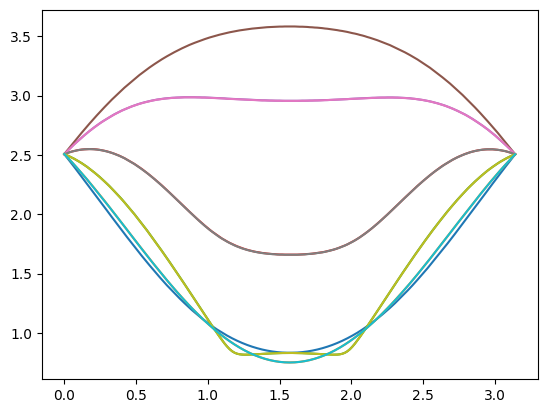

In [27]:
plt.figure()
for i in range(10):
    plt.plot(theta, gain[0, :, 36*i])
plt.show()

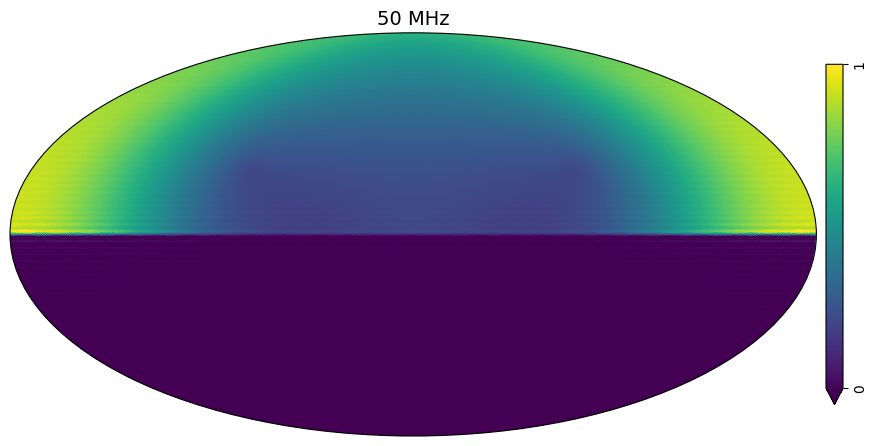

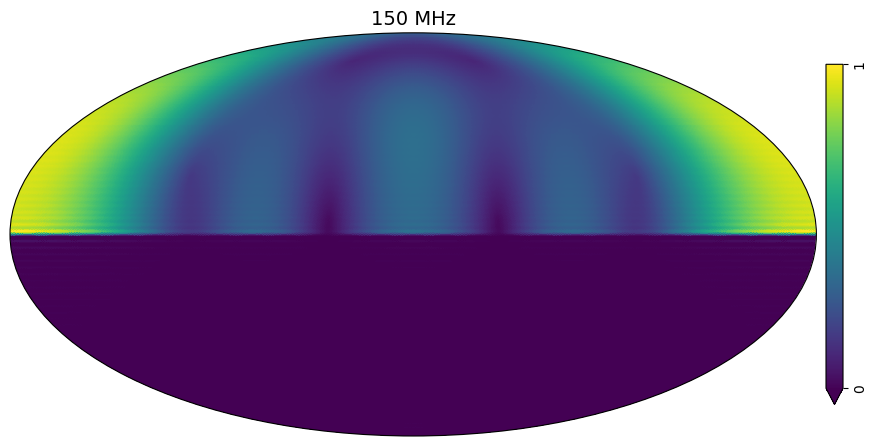

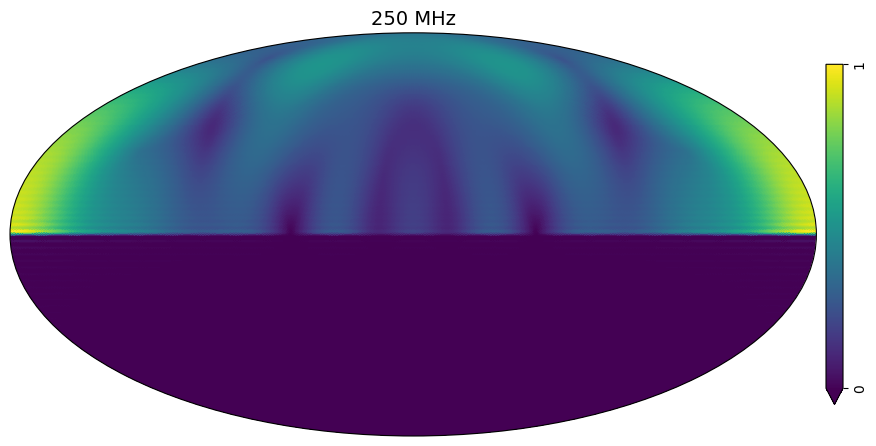

In [40]:
for i in [0, 100, 200]:
    hp.projview(beam_map[i]/beam_map[i].max(), title=f"{freqs[i]:.0f} MHz", cb_orientation="vertical", min=0, max=1)
    plt.show()

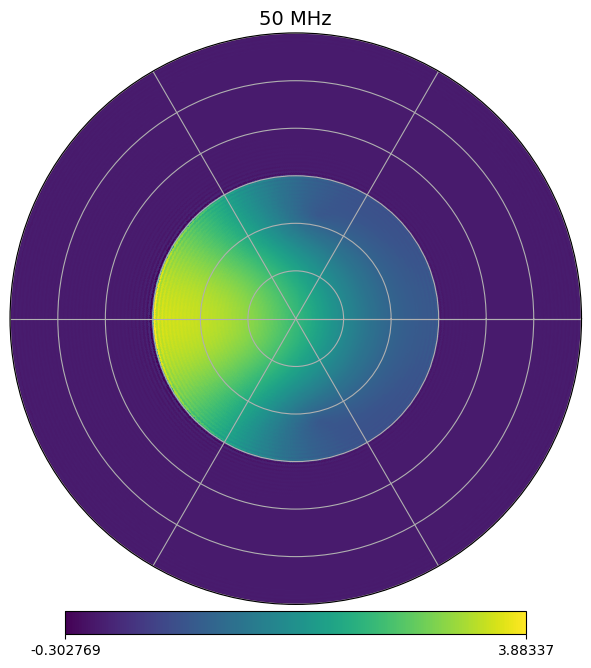

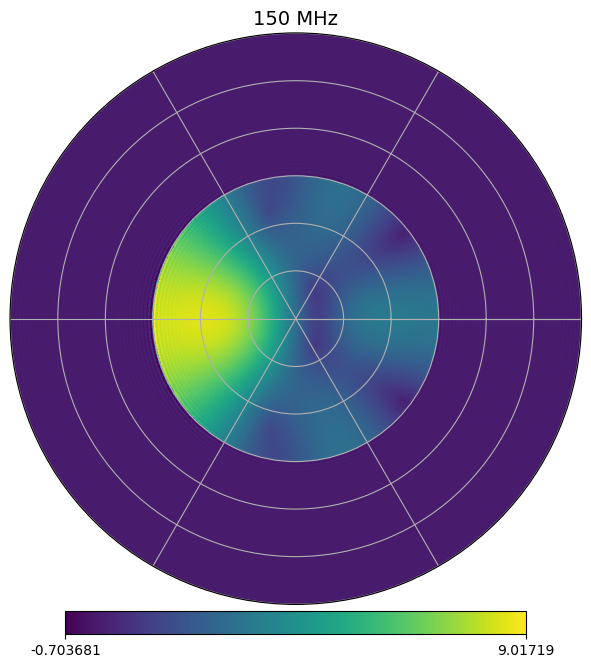

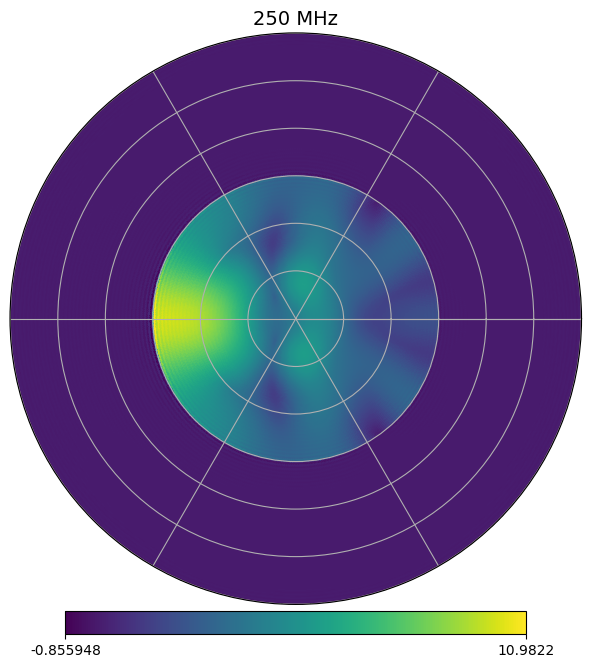

In [34]:
for i in [0, 100, 200]:
    hp.projview(beam_map[i, ::-1], title=f"{freqs[i]:.0f} MHz", projection_type="polar", graticule=True, rot=(0, 0, 0))
    plt.show()

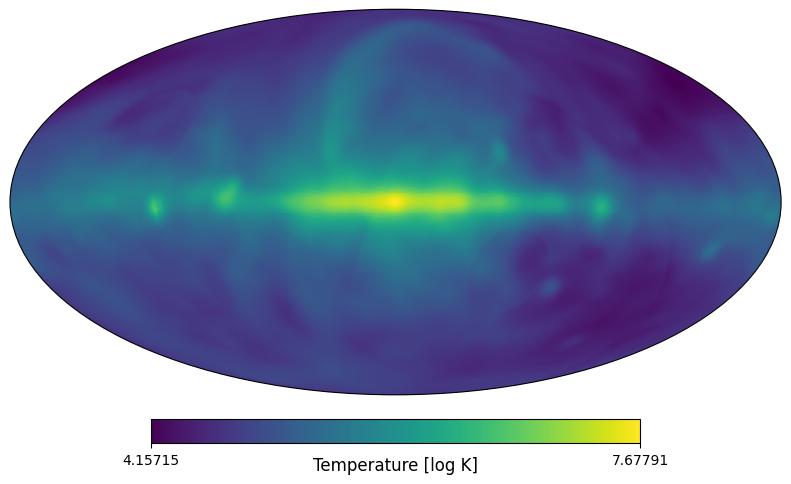

In [106]:
sky = cro.Sky.gsm(freqs, lmax=LMAX)
sky_map = sky.hp_map(NSIDE)
hp.projview(np.log(sky_map[150]), unit="Temperature [log K]"); plt.show()

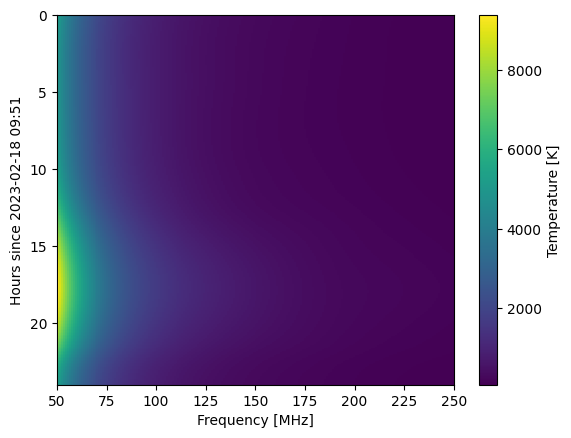

In [107]:
lat = 37.873199
lon = -122.257063
location = (lon, lat)
times = cro.simulator.time_array(t_start="2023-02-18 09:51", t_end="2023-02-19 09:51", N_times=250)
sim_kwargs = {"lmax": LMAX, "frequencies": freqs, "world": "earth", "location": location, "times": times}
sim = cro.Simulator(beam, sky, **sim_kwargs)
sim.run(dpss=False)
sim.plot()

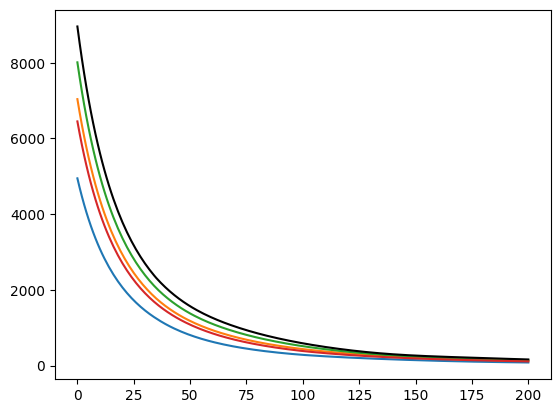

In [251]:
plt.plot(np.mean(data[:50], axis=0))
plt.plot(np.mean(data[-50:], axis=0))
plt.plot(np.mean(data[-100:], axis=0))
plt.plot(np.mean(data[150:208], axis=0), c="k")
plt.plot(np.mean(data, axis=0))

In [260]:
def dayenu(dat, freqs=freqs, width=1.):
    rdat = hera_filters.dspec.fourier_filter(
        x=freqs*1e6, data=dat, wgts=np.ones_like(dat), mode='dpss_leastsq', filter_centers=[0.],
        filter_half_widths=[width*1e-9], eigenval_cutoff=[1e-12], suppression_factors=[1e-9]
    )[1]
    return rdat

def gen_eor(freqs, A=0.5, nu0=78.3, w=20.7, tau=7):
    '''Generate a 21cm spectrum using Bowman et al. 2018 parameterization.'''
    B = 4 * (freqs - nu0)**2 / w**2 * np.log(-1/tau * np.log((1+np.exp(-tau))/2))
    return -A * (1 - np.exp(-tau * np.exp(B))) / (1 - np.exp(-tau))

fg_data = sim.waterfall.copy()
edges = gen_eor(freqs)
data = fg_data + edges
m = sky[:, 0, 0]

d = data - np.mean(data[:50], axis=0)
cov = d.T @ d
diag = np.sqrt(np.diag(cov))
#corr = cov / (diag[:, None] * diag[None, :])
u, s, vt = np.linalg.svd(cov)

iS = np.eye(s.size)
iS[:5, :5] = 0  # filter 5 modes
Cinv = vt.T @ iS @ u.T
pcal = Cinv @ data[55]

fdata = dayenu(data / pcal, width=1.) * pcal
fedges = dayenu(edges / pcal, width=1.) * pcal
fm = dayenu(m / pcal) * pcal

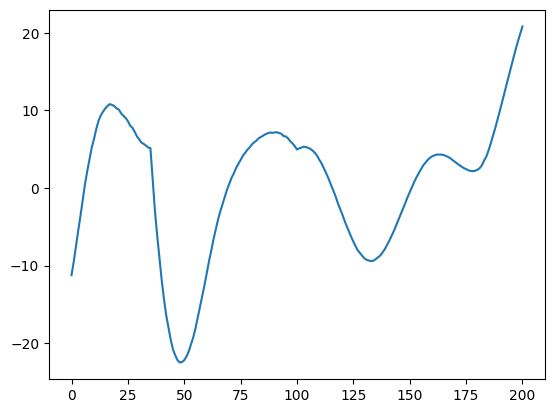

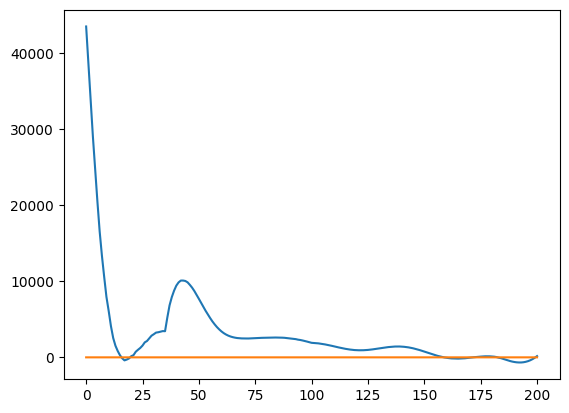

In [261]:
plt.figure()
plt.plot(pcal)
plt.show()

plt.figure()
plt.plot(fm)
plt.plot(fedges)
plt.show()

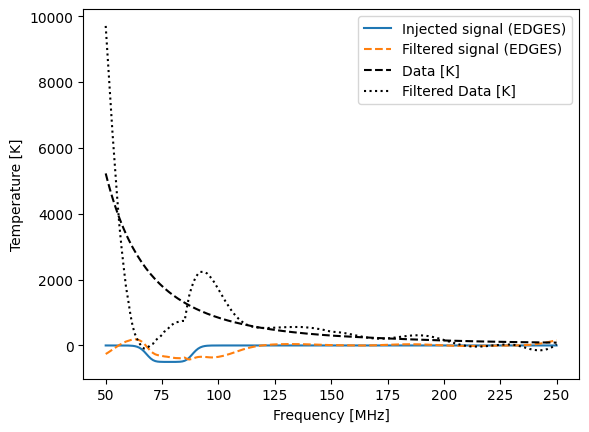

In [262]:
# Plot residuals to assess impact of filter
plt.figure()
plt.plot(freqs, edges*1e3, '-', label='Injected signal (EDGES)')
plt.plot(freqs, fedges*1e3, '--', label='Filtered signal (EDGES)')
plt.plot(freqs,  data[0], 'k--', label='Data [K]')
plt.plot(freqs, fdata[0], 'k:', label='Filtered Data [K]')
plt.xlabel('Frequency [MHz]')
plt.ylabel('Temperature [K]')
_ = plt.legend()

In [263]:
# Compute eigenmodes of filtered data
d = fdata - fdata.mean(axis=0)
C = d.T @ d
U, S, Vt = np.linalg.svd(C)

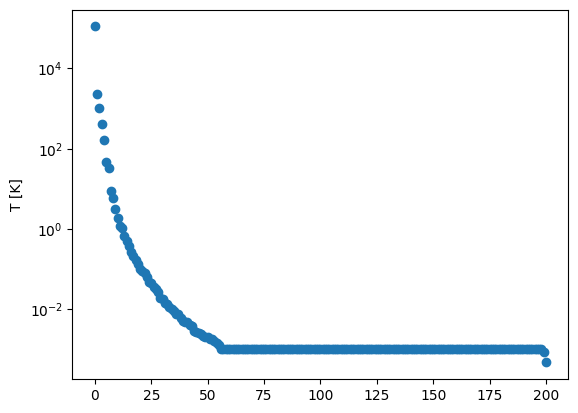

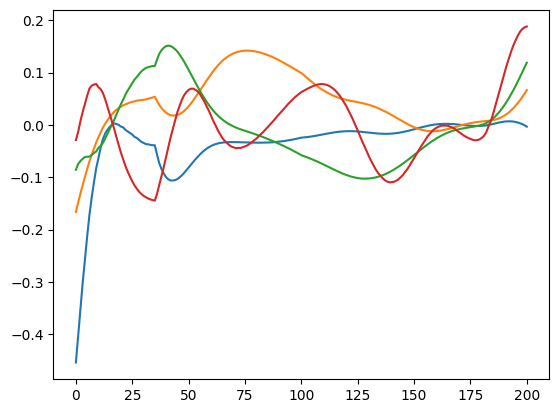

In [264]:
plt.figure()
plt.plot(np.sqrt(S), marker="o", ls="")
plt.yscale("log")
plt.ylabel("T [K]")
plt.show()

plt.figure()
plt.plot(Vt[:4].T)
plt.show()

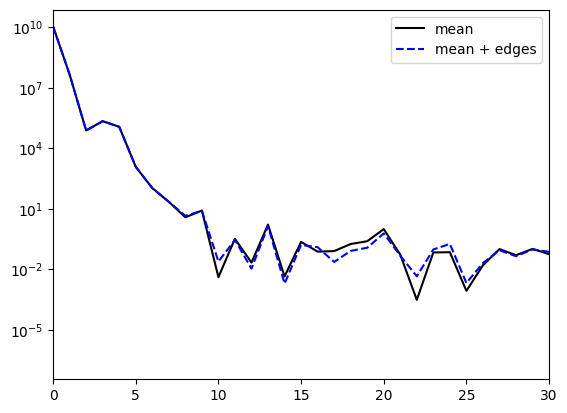

In [259]:
v = Vt.T
fg_proj = (fdata @ v)**2
#mean_proj = (fdata.mean(axis=0) @ v)**2
#edges_proj = ((fdata.mean(axis=0)+fedges) @ v)**2
#print(mean_proj.sum() / edges_proj.sum())
mean_proj = (fm @ v)**2
edges_proj = ((fm+fedges) @ v)**2


plt.figure()
#plt.plot(fg_proj[::10].T)
plt.plot(mean_proj, lw=1.5, c="k", label="mean")
plt.plot(edges_proj, lw=1.5, c="b", ls="--", label="mean + edges")
plt.legend()
plt.yscale("log")
plt.xlim(0, 30)
plt.show()